In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
#using kaggle api to download the dataset directly
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
100% 545M/545M [00:26<00:00, 22.8MB/s]
100% 545M/545M [00:26<00:00, 21.5MB/s]


In [3]:
#unzipping the data
import zipfile
zip_ref = zipfile.ZipFile('/content/cat-dog-images-for-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [4]:
#importing the necessary libraries
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
import shutil
import os

In [5]:
#making subfolder for cat and dogs
source_dir = '/content/cat_dog'

cat_dir = '/content/cat_dog/cat'
dog_dir = '/content/cat_dog/dog'

os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

for filename in os.listdir(source_dir):
    if os.path.isfile(os.path.join(source_dir, filename)) and filename.startswith("cat"):
        shutil.move(os.path.join(source_dir, filename), os.path.join(cat_dir, filename))
    elif os.path.isfile(os.path.join(source_dir, filename)) and filename.startswith("dog"):
        shutil.move(os.path.join(source_dir, filename), os.path.join(dog_dir, filename))

In [6]:
#spitting the data into train and test
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/cat_dog',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training'
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/cat_dog',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [7]:
#normalizing the data
def process(image,label):
  image = tf.cast(image/255. ,tf.float32)
  return image,label

train_dataset = train_dataset.map(process)
validation_dataset = validation_dataset.map(process)

In [8]:
model = Sequential()

# First Convolutional Block
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Second Convolutional Block
model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(BatchNormalization())
model.add(Conv2D(34, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Third Convolutional Block
model.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(BatchNormalization())
model.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Global Average Pooling to reduce parameters
model.add(GlobalAveragePooling2D())

# Fully Connected Layers
model.add(Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dropout(0.3))  # Increased dropout to prevent overfitting

model.add(Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model.add(Dropout(0.3))

model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuil

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)

In [11]:
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [13]:
history = model.fit(train_dataset,epochs=20,validation_data=validation_dataset,callbacks=[early_stopping])

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 187ms/step - accuracy: 0.5741 - loss: 0.6828 - val_accuracy: 0.5996 - val_loss: 0.6508
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 111s 177ms/step - accuracy: 0.6227 - loss: 0.6336 - val_accuracy: 0.5994 - val_loss: 0.8249
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 178ms/step - accuracy: 0.6783 - loss: 0.5935 - val_accuracy: 0.6926 - val_loss: 0.6061
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 181ms/step - accuracy: 0.7332 - loss: 0.5424 - val_accuracy: 0.6386 - val_loss: 0.8207
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - accuracy: 0.7599 - loss: 0.5043 - val_accuracy: 0.7676 - val_loss: 0.4945
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 178ms/step - accuracy: 0.7801 - loss: 0.4684 - val_accuracy: 0.7358 - val_loss: 0.6166
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - accuracy: 0.8116 - loss: 0.4235 - val_accuracy: 0.7594 - val_loss: 0.5988
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - accuracy: 0.8327 -

In [20]:
# Save the model
model.save('my_model.h5')
model.save_weights('model_weights.weights.h5')

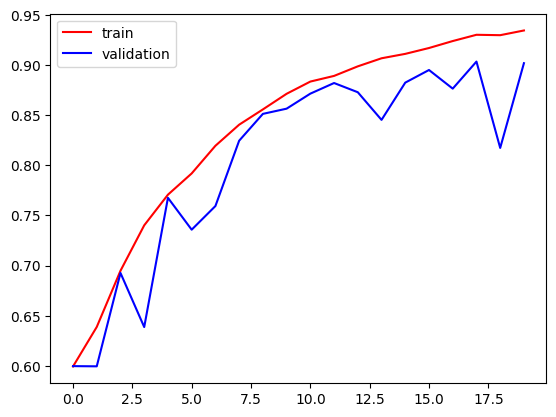

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

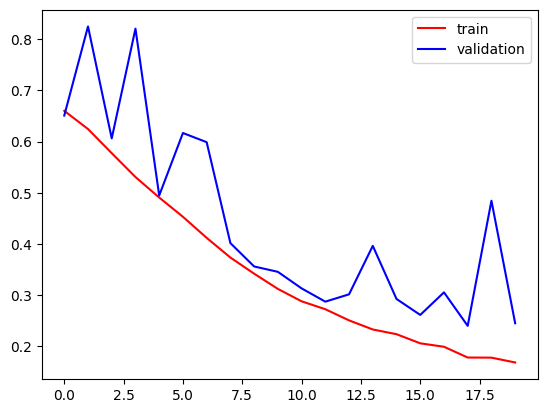

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [16]:
#Training the model with data augmentation

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)  # 20% of the data will be used for validation

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        '//content/cat_dog',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary',
        subset='training')  # This will use the training part of the split

validation_generator = train_datagen.flow_from_directory(
        '//content/cat_dog',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='binary',
        subset='validation')  # This will use the validation part of the split


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [23]:
model1 = Sequential()

# First Convolutional Block
model1.add(BatchNormalization())
model1.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Second Convolutional Block
model1.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model1.add(BatchNormalization())
model1.add(Conv2D(34, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Third Convolutional Block
model1.add(Conv2D(16, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model1.add(BatchNormalization())
model1.add(Conv2D(8, kernel_size=(3,3), padding='same', activation='relu',
                 kernel_initializer=tf.keras.initializers.HeNormal()))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2), strides=2))

# Global Average Pooling to reduce parameters
model1.add(GlobalAveragePooling2D())

# Fully Connected Layers
model1.add(Dense(64, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model1.add(Dropout(0.3))  # Increased dropout to prevent overfitting

model1.add(Dense(32, activation='relu', kernel_initializer=tf.keras.initializers.HeNormal()))
model1.add(Dropout(0.3))

model1.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification

In [24]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_12               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuil

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:
model1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [27]:
history1 = model1.fit(train_generator,epochs=25,validation_data=validation_generator,callbacks=[early_stopping])

Epoch 1/25


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


625/625 ━━━━━━━━━━━━━━━━━━━━ 440s 680ms/step - accuracy: 0.5698 - loss: 0.6997 - val_accuracy: 0.6234 - val_loss: 0.6341
Epoch 2/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 436s 680ms/step - accuracy: 0.6350 - loss: 0.6323 - val_accuracy: 0.6846 - val_loss: 0.5927
Epoch 3/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 439s 676ms/step - accuracy: 0.6984 - loss: 0.5814 - val_accuracy: 0.7348 - val_loss: 0.5324
Epoch 4/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 426s 677ms/step - accuracy: 0.7306 - loss: 0.5387 - val_accuracy: 0.7342 - val_loss: 0.5426
Epoch 5/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 440s 674ms/step - accuracy: 0.7552 - loss: 0.5147 - val_accuracy: 0.7264 - val_loss: 0.5301
Epoch 6/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 440s 669ms/step - accuracy: 0.7874 - loss: 0.4724 - val_accuracy: 0.7944 - val_loss: 0.4487
Epoch 7/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 436s 662ms/step - accuracy: 0.8065 - loss: 0.4329 - val_accuracy: 0.7030 - val_loss: 0.6555
Epoch 8/25
625/625 ━━━━━━━━━━━━━━━━━━━━ 418s 665ms/step - accuracy: 0.8298 - loss: 0.39

In [30]:
# Save the model
model1.save('my_model1.keras')
model1.save_weights('model_weights1.weights.h5')

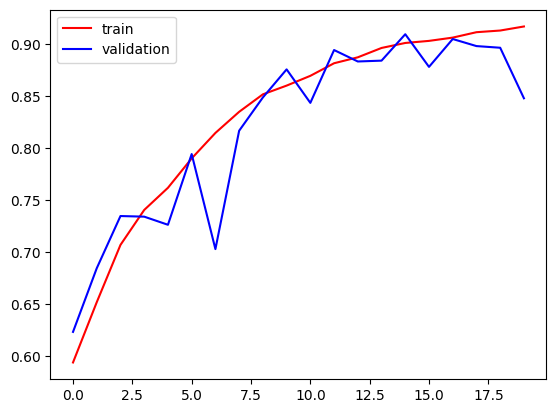

In [33]:
import matplotlib.pyplot as plt
plt.plot(history1.history['accuracy'],color='red',label='train')
plt.plot(history1.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

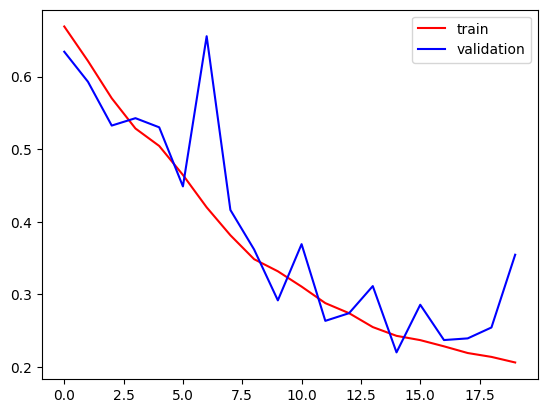

In [32]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'],color='red',label='train')
plt.plot(history1.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [65]:
import cv2

In [66]:
test_image1 = cv2.imread('/content/animal1.jpg')

In [67]:
test_image2 = cv2.imread('/content/animal2.jpg')

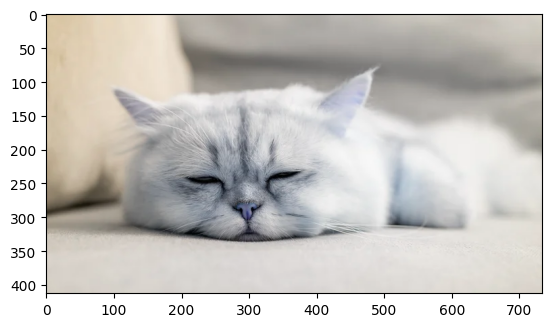

In [68]:
plt.imshow(test_image1)

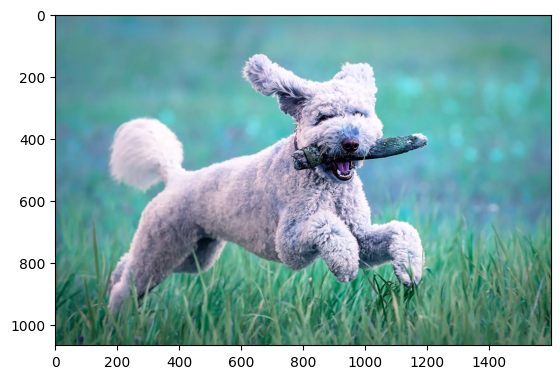

In [69]:
plt.imshow(test_image2)

In [70]:
print(test_image1.shape)
print(test_image2.shape)

(413, 734, 3)
(1067, 1600, 3)


In [71]:
test_image1 = cv2.resize(test_image1,(256,256))
test_image2 = cv2.resize(test_image2,(256,256))

In [72]:
test_image1 = test_image1.reshape(1,256,256,3)
test_image2 = test_image2.reshape(1,256,256,3)

In [73]:
output1 = model1.predict(test_image1)
binary_prediction = (output1 >= 0.5).astype(int)

print(binary_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0]]


In [75]:
output2 = model1.predict(test_image2)

binary_prediction = (output2 >= 0.5).astype(int)

print(binary_prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[1]]
